In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from get_dataset import acsincom

from model import MCLogisticRegression 
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference
#Fairness Analysis
#https://fairlearn.org/main/user_guide/assessment/common_fairness_metrics.html

In [2]:
income = acsincom(num_data= 300000) # MAX 1664500
X_st, y_st, X_all, y_all, sex_all, race_all, state_list  = income.getData()

(300000, 798)


In [15]:
#Federated Learning.
testing_acc = []
iteration = 200
fedavg_weight = None
fedavg_intercept = None

fedavg_eod_race = []
fedavg_eod_sex = []
fedavg_dpr_race = []
fedavg_dpr_sex = []

last_acc = None
last_so_eod_race = None
last_so_eod_sex = None
last_so_dpr_race = None
last_so_dpr_sex = None

for i in range(iteration):
    weights = []
    intercepts = []
    each_testing_acc = []
    
    so_eod_race = []
    so_eod_sex = []
    so_dpr_race = []
    so_dpr_sex = []
    
    for st in state_list:
        #get only data for the st(state.)
        X = X_st[st]["X"]
        sex = X_st[st]["sex"]
        race = X_st[st]["race"]
        y = y_st[st]
        
        X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                                train_test_split(X, y, sex, race, test_size=0.3)
        model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                     0.035, 1, 2, fedavg_weight, 
                                     fedavg_intercept)
        model.train()
        y_pred = model.predict(X_test)
        acc = np.mean(y_pred == y_test)
        weights.append(model.w.tolist())
        intercepts.append(model.b.tolist())
        each_testing_acc.append(acc)
        
        #Calculate OE and DP
        eod_race = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
        eod_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
        dpr_race = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
        dpr_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
        
        #Store OE and DP for each state.
        so_eod_race.append(eod_race)
        so_eod_sex.append(eod_sex)
        so_dpr_race.append(dpr_race)
        so_dpr_sex.append(dpr_sex)
    if(i %20 ==0):
        print("iteration", i)
    
    #mean of weights and update the fedavg weights and intercept
    fedavg_weight = np.array(weights).mean(axis=0)
    fedavg_intercept = np.array(intercepts).mean()
    testing_acc.append(np.mean(each_testing_acc))
    
    #mean of EO and DP for all states.
    fedavg_eod_race.append(np.mean(so_eod_race))
    fedavg_eod_sex.append(np.mean(so_eod_sex))
    fedavg_dpr_race.append(np.mean(so_dpr_race))
    fedavg_dpr_sex.append(np.mean(so_dpr_sex))
    
    if(i == (iteration -1)):
        last_acc = each_testing_acc
        last_so_eod_race = so_eod_race
        last_so_eod_sex = so_eod_sex
        last_so_dpr_race = so_dpr_race
        last_so_dpr_sex = so_dpr_sex

        

iteration 0
iteration 20
iteration 40
iteration 60
iteration 80
iteration 100
iteration 120
iteration 140
iteration 160
iteration 180


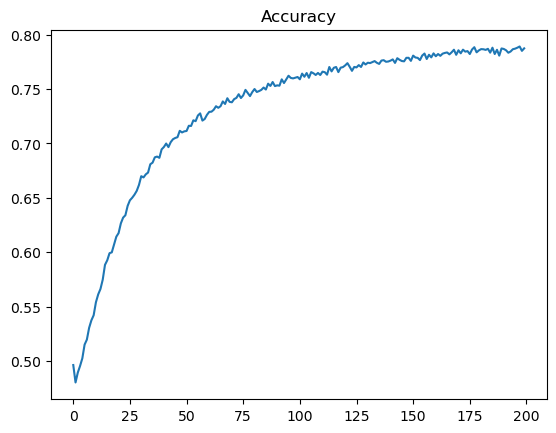

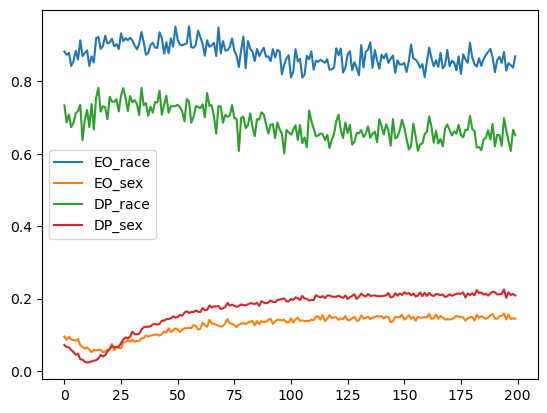

FedAvg
Accuracy 0.7873430624366122
EO_race 0.869005352876692
EO_sex 0.1448824794664408
DP_race 0.6507319988514843
DP_sex 0.20894569971698806


In [16]:
plt.plot(testing_acc)
plt.title("Accuracy")
plt.show()

plt.plot(fedavg_eod_race, label='EO_race')
plt.plot(fedavg_eod_sex, label='EO_sex')
plt.plot(fedavg_dpr_race,label='DP_race')
plt.plot(fedavg_dpr_sex,label='DP_sex')
plt.legend()
plt.show()

print("FedAvg")
print("Accuracy", testing_acc[-1])
print("EO_race", fedavg_eod_race[-1])
print("EO_sex", fedavg_eod_sex[-1])
print("DP_race", fedavg_dpr_race[-1])
print("DP_sex", fedavg_dpr_sex[-1])

0.7885666666666666
Centralized
Accuracy 0.7885666666666666
EO_race 0.8614718614718615
EO_sex 0.10392345346654772
DP_race 0.7549583213567117
DP_sex 0.1851954638392599


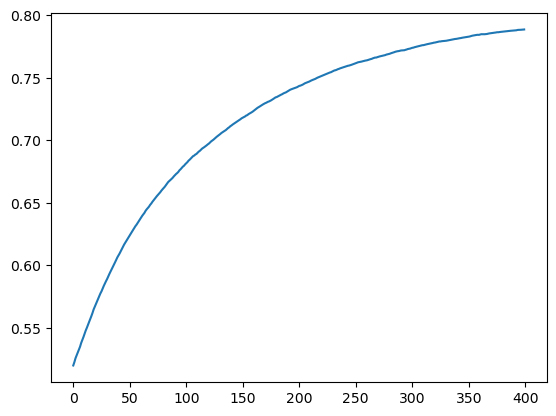

In [14]:
global_X = []
global_y = []
global_sex = []
global_race = []

for st in state_list:
    global_X.extend(X_st[st]["X"])
    global_sex.extend(X_st[st]["sex"])
    global_race.extend(X_st[st]["race"])
    global_y.extend(y_st[st])
    
global_X_np = np.array(global_X)
global_sex_np = np.array(global_sex)
global_race_np = np.array(global_race)
global_y_np = np.array(global_y)

#print(np.shape(global_X_np), np.shape(global_sex_np), np.shape(global_race_np ),np.shape(global_y_np))

X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                                train_test_split(global_X_np, global_y_np, global_sex_np, global_race_np, test_size=0.3)
model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                     0.1, 400, 2)
model.train(eval=True)
y_pred = model.predict(X_test)
acc = np.mean(y_pred == y_test) 

eod_race = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
eod_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
dpr_race = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
dpr_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)

print(acc)
print("Centralized")
print("Accuracy", acc)
print("EO_race", eod_race)
print("EO_sex", eod_sex)
print("DP_race", dpr_race)
print("DP_sex", dpr_sex)

plt.plot(model.test_acc)
plt.show()

In [17]:
so_eod_race_sum = 0
so_eod_sex_sum = 0
so_dpr_race_sum = 0
so_dpr_sex_sum = 0
acc_sum = 0

count = 0
i = 0
for st in state_list:
    st_num = len(y_st[st])
    count += st_num
    
    acc_sum += st_num * last_acc[i]
    so_eod_race_sum += st_num * last_so_eod_race[i]
    so_eod_sex_sum += st_num *last_so_eod_sex[i]
    so_dpr_race_sum += st_num * last_so_dpr_race[i]
    so_dpr_sex_sum  += st_num * last_so_dpr_sex[i]
    i +=1
    
print(so_eod_race_sum/count)
print(so_eod_sex_sum/count)
print(so_dpr_race_sum /count)
print(so_dpr_sex_sum /count)
print(acc_sum/count)

0.7897456157598042
0.13689754777999927
0.6180863276984075
0.20292088233088712
0.7861294878871106


In [18]:
testing_acc = []
testing_acc_array = []

so_eod_race = []
so_eod_sex = []
so_dpr_race = []
so_dpr_sex = []

for st in state_list:
    #get only data for the st(state.)
    X = X_st[st]["X"]
    sex = X_st[st]["sex"]
    race = X_st[st]["race"]
    y = y_st[st]
    
    X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                            train_test_split(X, y, sex, race, test_size=0.3)
    model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                    0.03, 600, 2)
    model.train(eval=True)
    y_pred = model.predict(X_test)
    #acc = np.mean(y_pred == y_test)
    testing_acc.append(model.test_acc[-1])
    testing_acc_array.append(model.test_acc)
    
    #Calculate OE and DP
    eod_race = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
    eod_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
    dpr_race = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
    dpr_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
    
    #Store OE and DP for each state.
    so_eod_race.append(eod_race)
    so_eod_sex.append(eod_sex)
    so_dpr_race.append(dpr_race)
    so_dpr_sex.append(dpr_sex)

In [ ]:
sum = 0
count = 0
i = 0
for st in state_list:
    st_num = len(y_st[st])
    count += st_num
    sum += st_num * testing_acc[i]
    i +=1
    
print(sum/count)

Standalone
Accuracy 0.7131480711742221
EO_race 0.8904688923879647
EO_sex 0.13535824827007265
DP_race 0.7148334689953542
DP_sex 0.1698674895404801


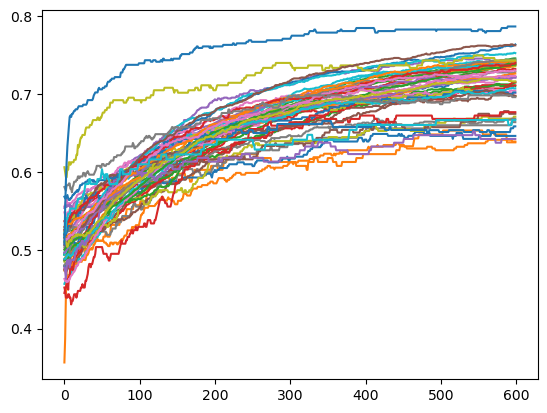

In [19]:
print("Standalone")
print("Accuracy", np.mean(testing_acc))
print("EO_race", np.mean(so_eod_race))
print("EO_sex", np.mean(so_eod_sex))
print("DP_race", np.mean(so_dpr_race))
print("DP_sex", np.mean(so_dpr_sex))

for i in range(len(state_list)):
    plt.plot(testing_acc_array[i])
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                train_test_split(X_all, y_all, sex_all, race_all, test_size=0.3)
                
clf = LogisticRegression().fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

eod_race = equalized_odds_difference(y_test, y_test_pred, sensitive_features=race_test)
eod_sex = equalized_odds_difference(y_test, y_test_pred, sensitive_features=sex_test)
dpr_race = demographic_parity_difference(y_test, y_test_pred, sensitive_features=race_test)
dpr_sex = demographic_parity_difference(y_test, y_test_pred, sensitive_features=sex_test)

print("Centralized")
print("Accuracy", clf.score(X_test,y_test))
print("EO_Race:", eod_race)
print("EO_Sex: ", eod_sex)
print("DP_Race:", dpr_race)
print("DP_Sex: ", dpr_sex)